<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [83]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [84]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

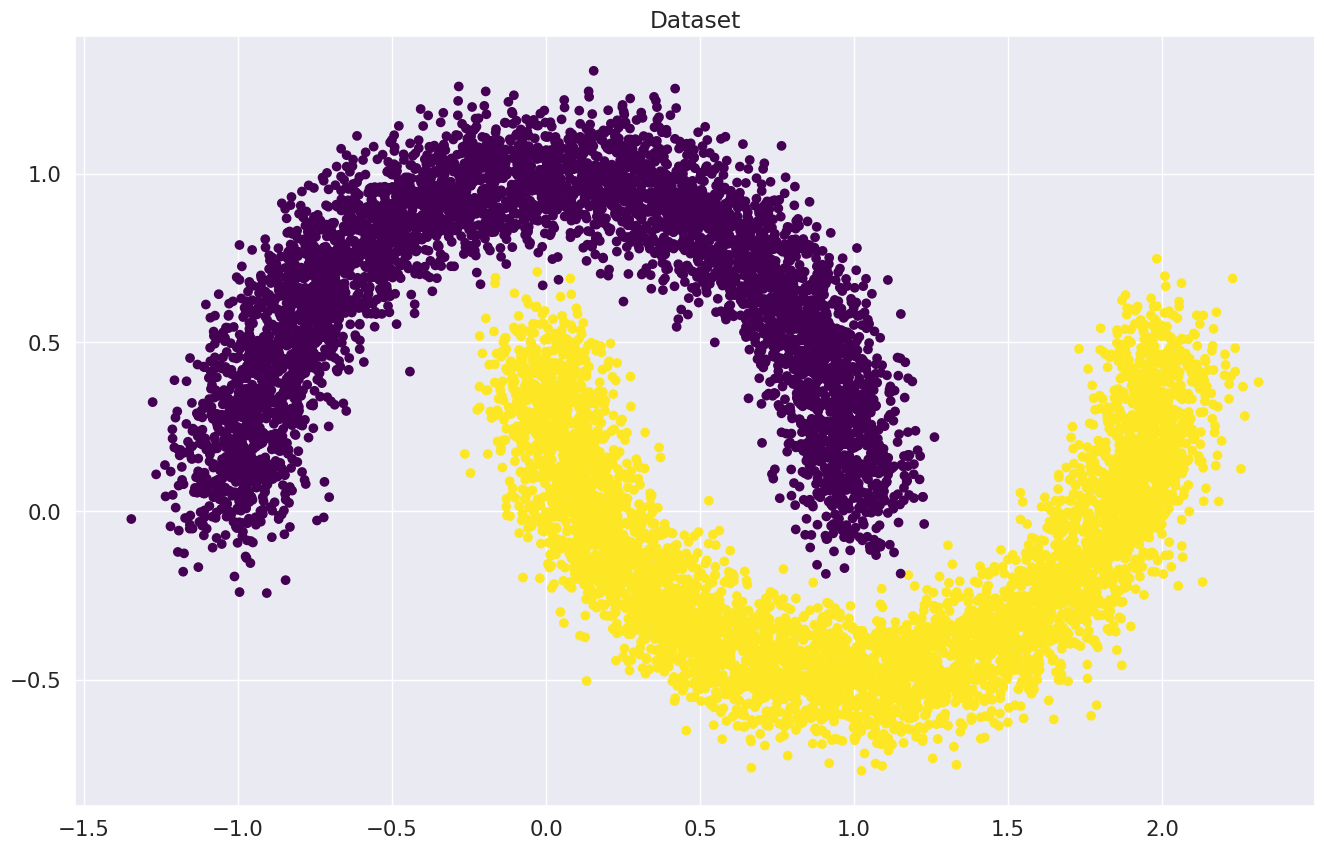

In [85]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [86]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [87]:
X_train_t = torch.FloatTensor(X_train) # YOUR CODE GOES HERE
y_train_t = torch.FloatTensor(y_train) # YOUR CODE GOES HERE
X_val_t = torch.FloatTensor(X_val) # YOUR CODE GOES HERE
y_val_t = torch.FloatTensor(y_val) # YOUR CODE GOES HERE

Создаем `Dataset` и `DataLoader`. 

In [88]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

In [89]:
X_train_t.shape, y_train_t.shape

(torch.Size([7500, 2]), torch.Size([7500]))

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к классу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоиды. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [90]:
torch.randn((7500,2))

tensor([[ 0.4972, -0.8366],
        [-0.5382, -1.3092],
        [ 0.0901, -0.0360],
        ...,
        [ 0.1049, -0.6824],
        [ 0.7871,  1.1212],
        [-1.8696, -1.6430]])

In [92]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn((2,1)))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn((1,1))) # YOUR CODE GOES HERE

    def forward(self, x):
        x = x @ self.weights# YOUR CODE GOES HERE
        if self.bias:
            x += self.bias_term # YOUR CODE GOES HERE
        return x

In [93]:
# отладка выходных размеров тензора
bias_t = torch.randn((1,1))
wei = torch.randn((2,1))
ou = X_train_t[0:5] @ wei
out = X_train_t[0:5] @ wei + bias_t
ou, ou.shape, out, out.shape, out[0].shape

(tensor([[ 0.1645],
         [ 0.2811],
         [ 1.7107],
         [-0.4826],
         [ 0.1017]]),
 torch.Size([5, 1]),
 tensor([[ 0.2188],
         [ 0.3354],
         [ 1.7650],
         [-0.4283],
         [ 0.1560]]),
 torch.Size([5, 1]),
 torch.Size([1]))

In [94]:
# Изменение формы
out.view(-1), out

(tensor([ 0.2188,  0.3354,  1.7650, -0.4283,  0.1560]),
 tensor([[ 0.2188],
         [ 0.3354],
         [ 1.7650],
         [-0.4283],
         [ 0.1560]]))

In [95]:
out.flatten()

tensor([ 0.2188,  0.3354,  1.7650, -0.4283,  0.1560])

In [96]:
# выбор измерения для вычисления вероятности
F.softmax(out, dim=1), F.softmax(out, dim=0)

(tensor([[1.],
         [1.],
         [1.],
         [1.],
         [1.]]),
 tensor([[0.1208],
         [0.1357],
         [0.5669],
         [0.0632],
         [0.1134]]))

In [97]:
(F.softmax(out, dim=0) > 0.5).type(torch.long)

tensor([[0],
        [0],
        [1],
        [0],
        [0]])

In [99]:
torch.sigmoid(out)

tensor([[0.5545],
        [0.5831],
        [0.8538],
        [0.3945],
        [0.5389]])

In [98]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [ ]:
#YOUR CODE
# Три параметра. Два параметра веса weights и свободный член bias_term
list(linear_regression.parameters())

[Parameter containing:
 tensor([[0.7882],
         [0.4719]], requires_grad=True),
 Parameter containing:
 tensor([[-1.0800]], requires_grad=True)]

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [100]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression(X_batch).view(-1) # YOUR CODE. Use linear_regression to get outputs
        loss = loss_function(outp, y_batch) # YOUR CODE. Compute loss
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.sigmoid(outp) # YOUR CODE. Compute probabilities #preds = torch.sigmoid(model(x_batch).round()
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.515625
Iteration: 100
Batch accuracy: 0.875
Iteration: 200
Batch accuracy: 0.8359375
Iteration: 300
Batch accuracy: 0.921875
Iteration: 400
Batch accuracy: 0.890625

Iteration: 460.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** **460**

### Визуализируем результаты

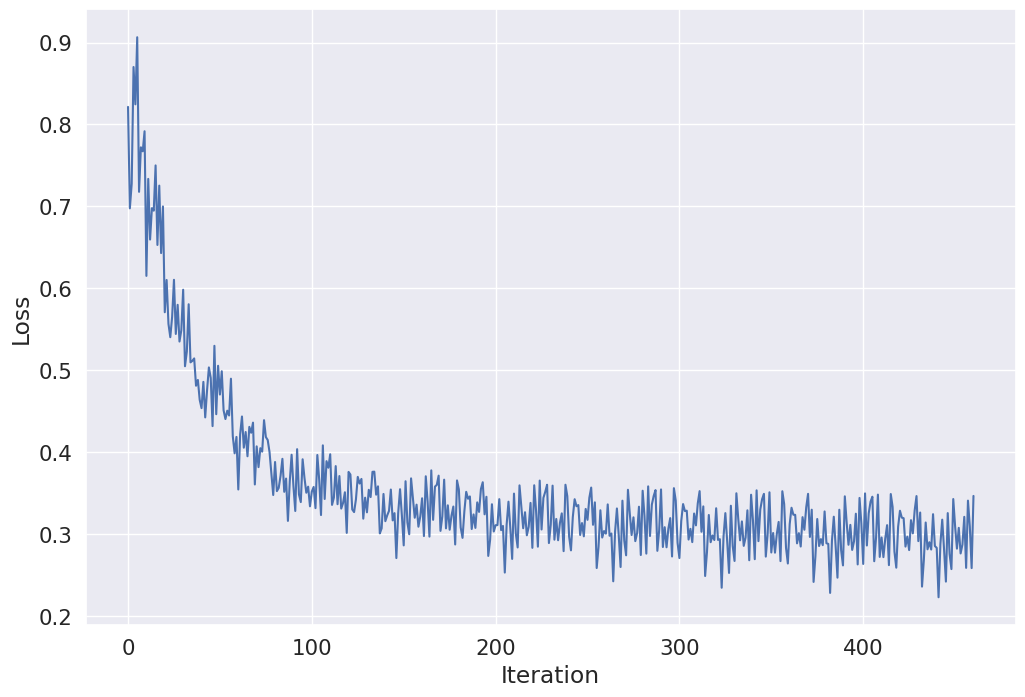

In [101]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

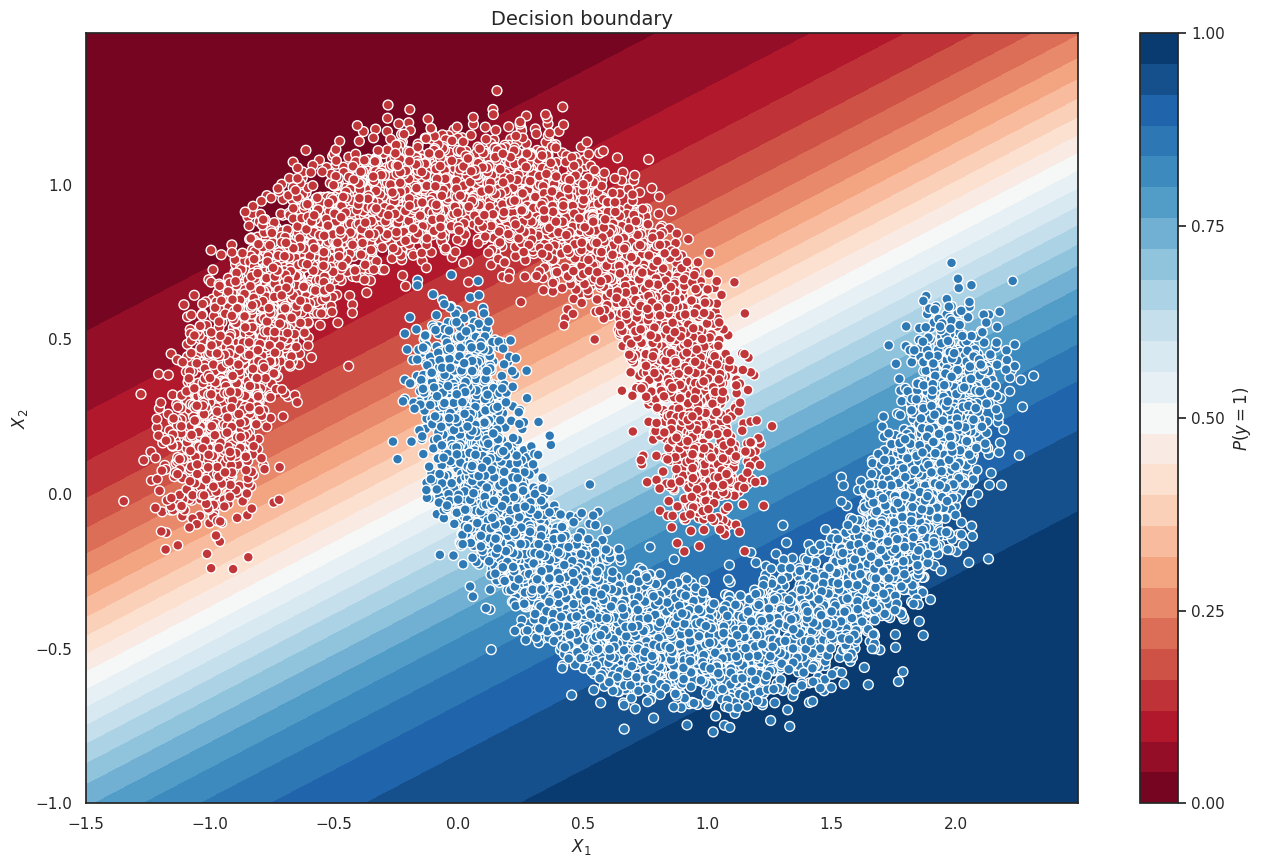

In [102]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [103]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        #<YOUR CODE>
        # вычисляем предсказание, потом вероятность с помощью softmax и назначаем метку, > 0.5 значит класс 1
        # preds = (F.softmax(model(x_batch), dim=0) > 0.5).type(torch.long) #YOUR CODE. Compute predictions
        preds = (torch.sigmoid(model(x_batch))  > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [104]:
len(predict(val_dataloader, linear_regression)), len(y_val)

(2500, 2500)

In [ ]:
predict(val_dataloader, linear_regression)

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
y_val

array([1, 1, 0, ..., 1, 0, 0])

In [105]:
from sklearn.metrics import accuracy_score

# YOUR CODE. Compute total accuracy
# предсказания сравниваем с исходным y_val, типа numpy
accuracy_score(predict(val_dataloader, linear_regression), y_val)

0.8716

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** **0.8716**

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [2]:
import os
from torchvision.datasets import MNIST
import torchvision.transforms as tfs

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader = DataLoader(train_dataset, batch_size=128)  # YOUR CODE GOES HERE
valid_dataloader = DataLoader(val_dataset, batch_size=128) # YOUR CODE GOES HERE

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [3]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [4]:
features = 784 # изображения размера 28x28
classes = 10   # targets это целое значение в диапазоне [0, 9] (10 классов)

In [11]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    #YOUR CODE. Add layers to your sequential class
    nn.Linear(features, 128),
    activation(),
    nn.Linear(128, classes)
)

In [6]:
criterion = nn.CrossEntropyLoss() #YOUR CODE. Select a loss function
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [8]:
# подбор получения размера y_batch
x_b, y_b = next(iter(train_dataloader))
x_b.shape, y_b.shape, len(y_b)

(torch.Size([128, 1, 28, 28]), torch.Size([128]), 128)

In [ ]:
# подбор способы вычисления переменной correct
x_v, y_v = next(iter(valid_dataloader))
(y_b == y_v).sum()

tensor(9)

In [ ]:
# вычисление Accuracy
(y_b == y_v).sum() / len(y_b)

tensor(0.0703)

In [ ]:
# печать Accuracy
print(f"Loader: Accuracy: {(y_b == y_v).sum() / len(y_b)}")

Loader: Accuracy: 0.0703125


In [9]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                 # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                 model.train()
                 optimizer.zero_grad()
                 outp = model(x_batch)
            else:
                 # YOUR CODE. Set model to ``eval`` mode and calculate outputs
                 model.eval()
                 with torch.no_grad():
                   outp = model(x_batch)
            preds = outp.argmax(-1)
            correct =  (preds == y_batch).sum() # YOUR CODE GOES HERE
            all =  len(y_batch) # YOUR CODE GOES HERE
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                # YOUR CODE. Calculate gradients and make a step of your optimizer
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.87345
Loader: valid. Accuracy: 0.9172
Epoch: 2
Loader: train. Accuracy: 0.9310833333333334
Loader: valid. Accuracy: 0.9431
Epoch: 3
Loader: train. Accuracy: 0.9522666666666667
Loader: valid. Accuracy: 0.955
Epoch: 4
Loader: train. Accuracy: 0.9630166666666666
Loader: valid. Accuracy: 0.9584
Epoch: 5
Loader: train. Accuracy: 0.9698666666666667
Loader: valid. Accuracy: 0.9634
Epoch: 6
Loader: train. Accuracy: 0.97475
Loader: valid. Accuracy: 0.9678
Epoch: 7
Loader: train. Accuracy: 0.9783166666666666
Loader: valid. Accuracy: 0.9695
Epoch: 8
Loader: train. Accuracy: 0.98115
Loader: valid. Accuracy: 0.9712
Epoch: 9
Loader: train. Accuracy: 0.9836833333333334
Loader: valid. Accuracy: 0.9732
Epoch: 10
Loader: train. Accuracy: 0.9856
Loader: valid. Accuracy: 0.9737


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [10]:
elu_accuracy = accuracy["valid"]
print(elu_accuracy)

[0.9172, 0.9431, 0.955, 0.9584, 0.9634, 0.9678, 0.9695, 0.9712, 0.9732, 0.9737]


In [12]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)

def test_activation_function(activation):#, train_dataloader, valid_dataloader):
    #YOUR CODE
    
    model = nn.Sequential(
      nn.Flatten(),
      nn.Linear(features, 128),
      activation(),
      nn.Linear(128, classes)
      )
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    loaders = {"train": train_dataloader, "valid": valid_dataloader}

    device = "cuda" if torch.cuda.is_available() else "cpu"

    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
      for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                 model.train()
                 optimizer.zero_grad()
                 outp = model(x_batch)
            else:
                 model.eval()
                 with torch.no_grad():
                   outp = model(x_batch)
            preds = outp.argmax(-1)
            correct =  (preds == y_batch).sum()
            all =  len(y_batch)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)
    return accuracy["valid"]




In [14]:
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(nn.ReLU) #YOUR CODE
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU) #YOUR CODE

Epoch: 1
Loader: train. Accuracy: 0.8667333333333334
Loader: valid. Accuracy: 0.9036
Epoch: 2
Loader: train. Accuracy: 0.90095
Loader: valid. Accuracy: 0.9049
Epoch: 3
Loader: train. Accuracy: 0.9057166666666666
Loader: valid. Accuracy: 0.9061
Epoch: 4
Loader: train. Accuracy: 0.9076
Loader: valid. Accuracy: 0.9076
Epoch: 5
Loader: train. Accuracy: 0.9091166666666667
Loader: valid. Accuracy: 0.9093
Epoch: 6
Loader: train. Accuracy: 0.9103333333333333
Loader: valid. Accuracy: 0.9096
Epoch: 7
Loader: train. Accuracy: 0.9111666666666667
Loader: valid. Accuracy: 0.9099
Epoch: 8
Loader: train. Accuracy: 0.9121166666666667
Loader: valid. Accuracy: 0.9106
Epoch: 9
Loader: train. Accuracy: 0.9127166666666666
Loader: valid. Accuracy: 0.9107
Epoch: 10
Loader: train. Accuracy: 0.9136333333333333
Loader: valid. Accuracy: 0.9106
Epoch: 1
Loader: train. Accuracy: 0.8676166666666667
Loader: valid. Accuracy: 0.9162
Epoch: 2
Loader: train. Accuracy: 0.9249166666666667
Loader: valid. Accuracy: 0.9387
Ep

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

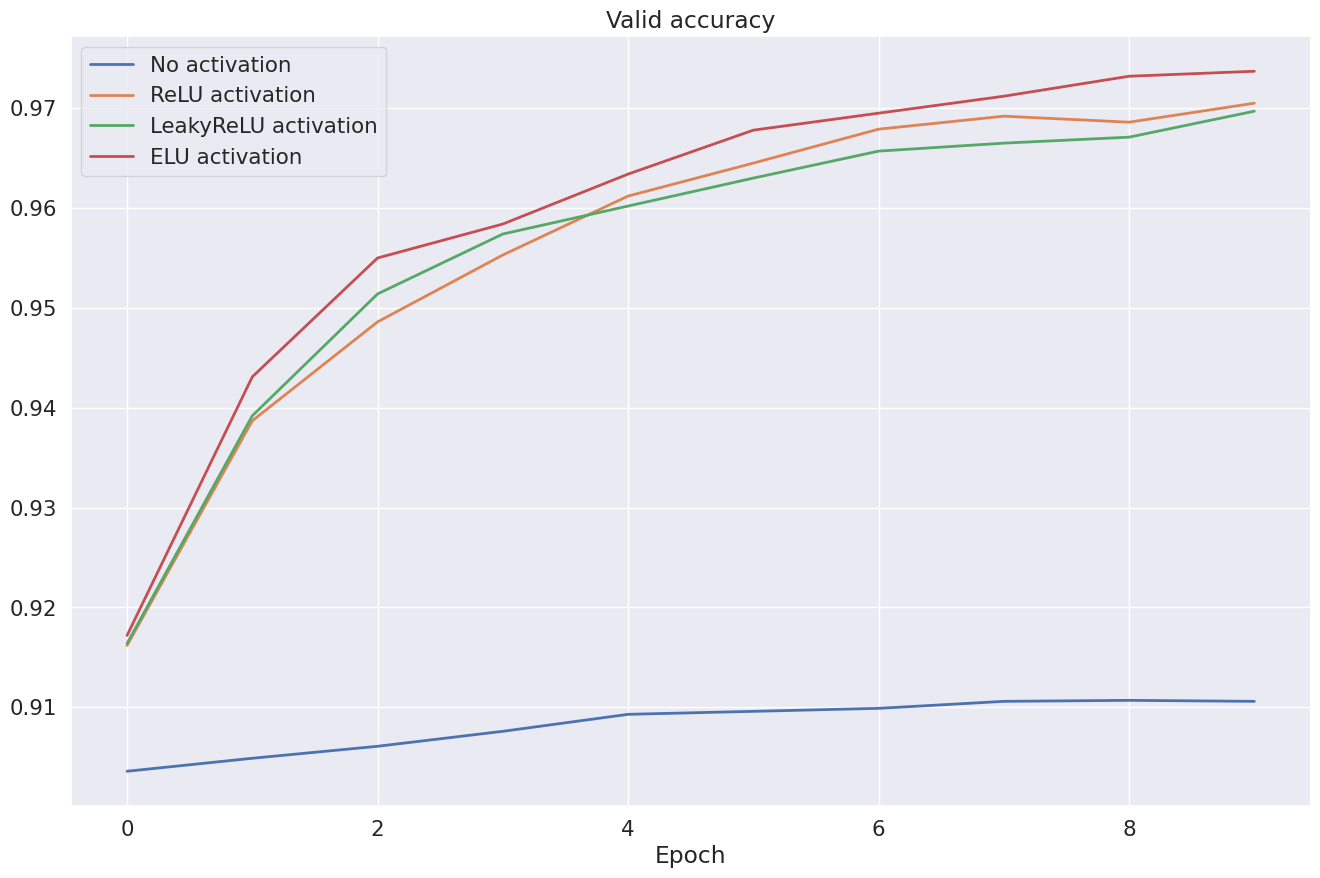

In [18]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

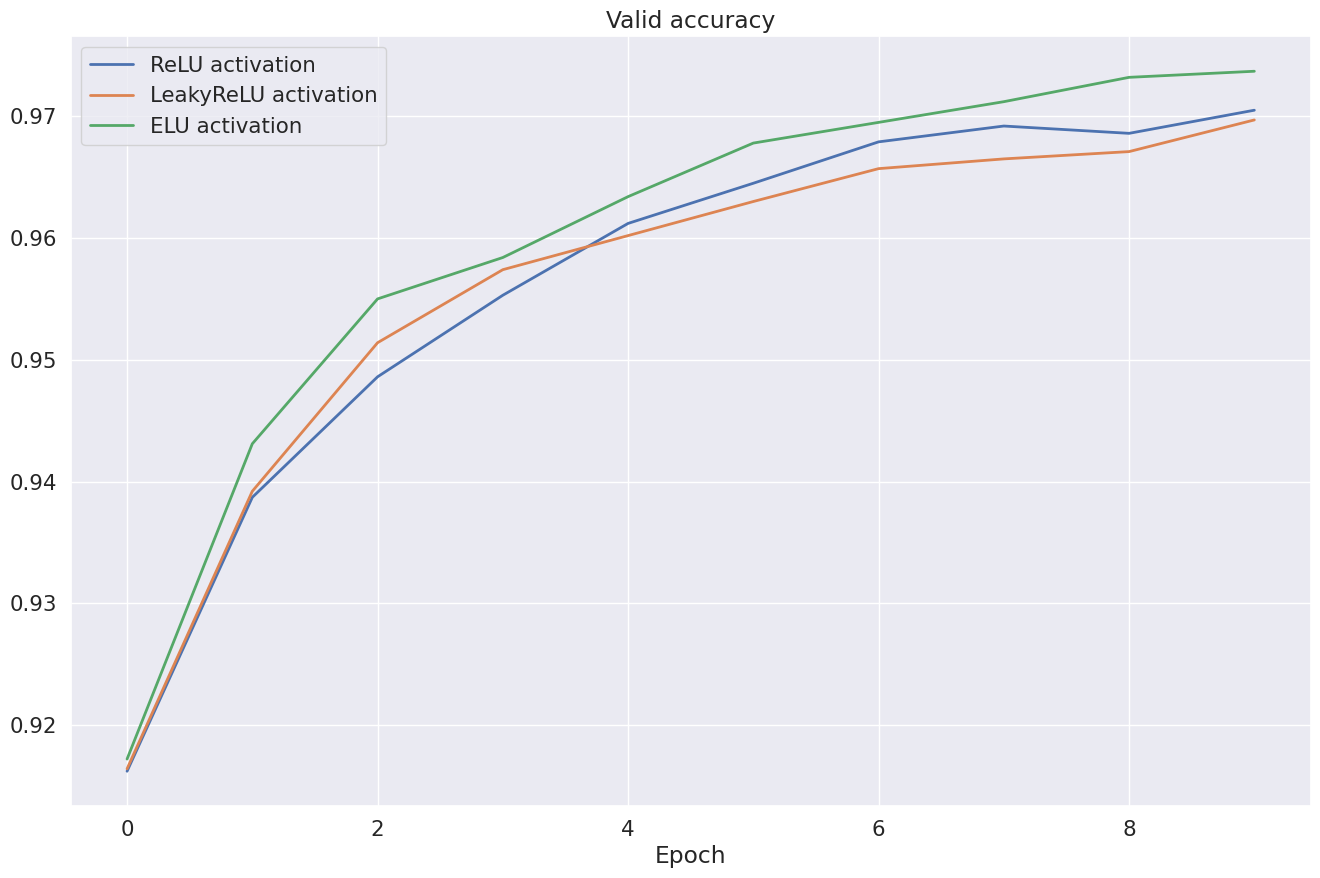

In [19]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** **ELU activation**

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [16]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2023-04-03 06:58:10--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2023-04-03 06:58:11--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 104.21.1.92, 172.67.128.246, 2606:4700:3036::ac43:80f6, ...
Connecting to img.the-village-kz.com (img.the-village-kz.com)|104.21.1.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K  --.-KB/s    in 0.002s  

2023-04-03 06:58:12 (2

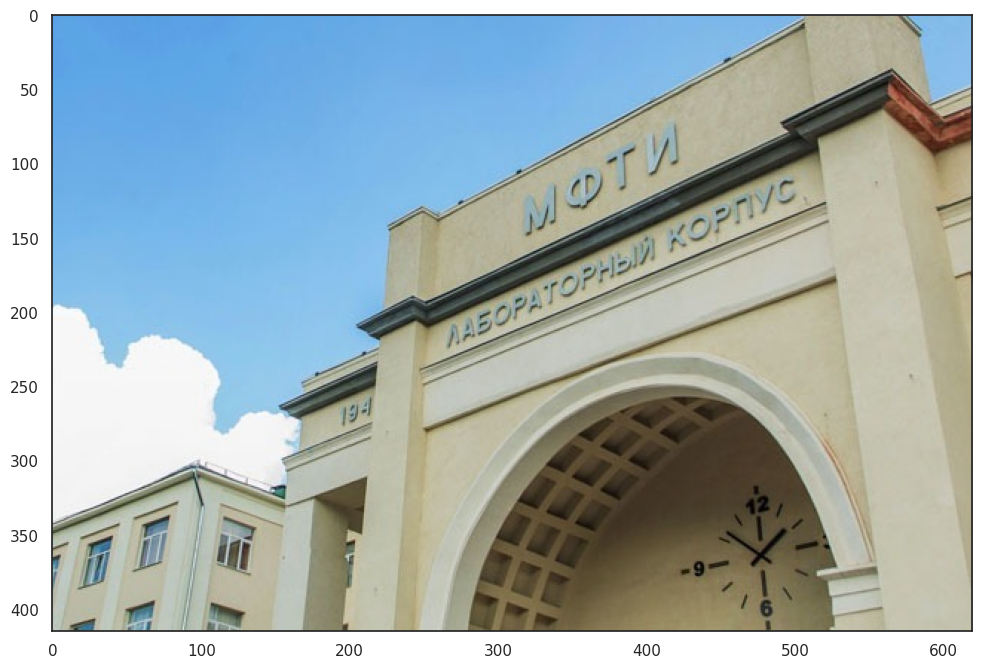

In [17]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте  
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [34]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

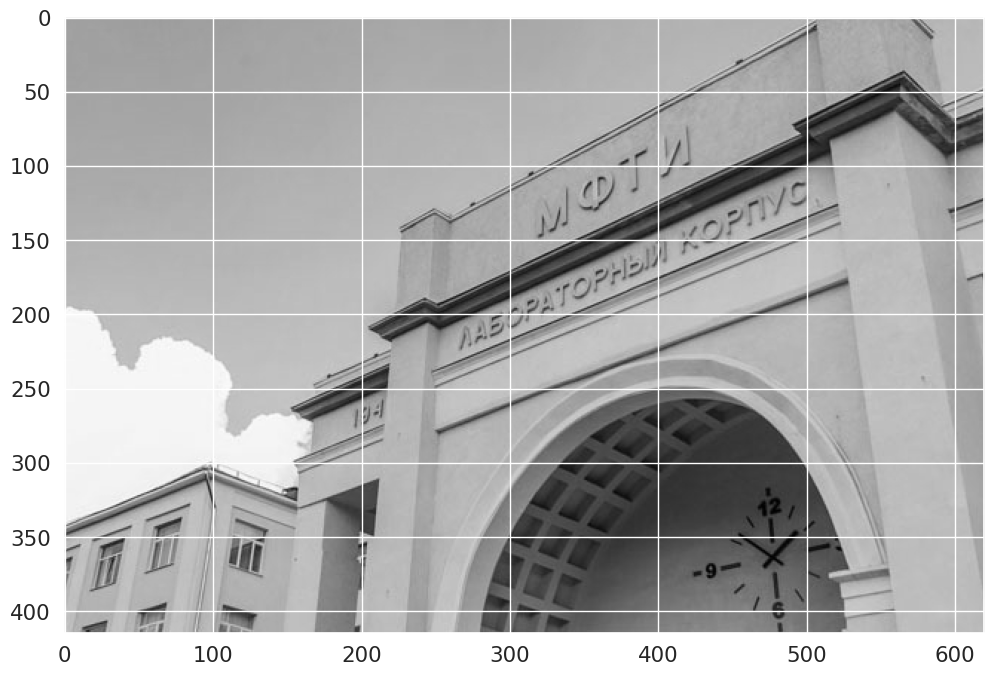

In [35]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:** 1 - Е, 2 - Д, 3 - 1, 4 - В, 5 - Б, 6 - Г

Не понял формулировку "Тождественное преобразование". Что это такое в нете и в лекциях не нашел.

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [76]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.act = nn.ReLU()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(kernel_size=2) #YOUR CODE
        self.conv2 = nn.Conv2d(6, 16, 3) #YOUR CODE
        self.pool2 = nn.MaxPool2d(kernel_size=2) #YOUR CODE
        self.flt = nn.Flatten()
        self.fc1 = nn.Linear(16 * 5 * 5, 120) #YOUR CODE  
        self.fc2 = nn.Linear(120, 84) #YOUR CODE
        self.fc3 = nn.Linear(84, 10) #YOUR CODE

    def forward(self, x):
        x = self.pool1(self.act(self.conv1(x))) #YOUR CODE. Apply layers created in __init__.
        x = self.pool2(self.act(self.conv2(x)))
        # print(x.shape) #для определения входного размера линейного слоя fc1
        x = self.flt(x)
        #x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [53]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [77]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [69]:
# код чтобы узнать входной размер для линейного слоя fc1
batch = []


batch = next(iter(train_dataloader))

model.forward(torch.FloatTensor(batch[0]))#.cuda())

TypeError: ignored

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [78]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                 # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                 model.train()
                 optimizer.zero_grad()
                 outp = model(x_batch)
            else:
                 # YOUR CODE. Set model to ``eval`` mode and calculate outputs
                 model.eval()
                 with torch.no_grad():
                   outp = model(x_batch)
            preds = outp.argmax(-1)
            correct =  (preds == y_batch).sum() # YOUR CODE GOES HERE
            all =  len(y_batch) # YOUR CODE GOES HERE
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                # YOUR CODE. Calculate gradients and make a step of your optimizer
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8828166666666667
Loader: valid. Accuracy: 0.9679
Epoch: 2
Loader: train. Accuracy: 0.96815
Loader: valid. Accuracy: 0.9764
Epoch: 3
Loader: train. Accuracy: 0.9775166666666667
Loader: valid. Accuracy: 0.9819
Epoch: 4
Loader: train. Accuracy: 0.98295
Loader: valid. Accuracy: 0.9846
Epoch: 5
Loader: train. Accuracy: 0.9857666666666667
Loader: valid. Accuracy: 0.9859
Epoch: 6
Loader: train. Accuracy: 0.9879166666666667
Loader: valid. Accuracy: 0.985
Epoch: 7
Loader: train. Accuracy: 0.99
Loader: valid. Accuracy: 0.9861
Epoch: 8
Loader: train. Accuracy: 0.9920833333333333
Loader: valid. Accuracy: 0.9855
Epoch: 9
Loader: train. Accuracy: 0.9928833333333333
Loader: valid. Accuracy: 0.9867
Epoch: 10
Loader: train. Accuracy: 0.99365
Loader: valid. Accuracy: 0.9854


In [79]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

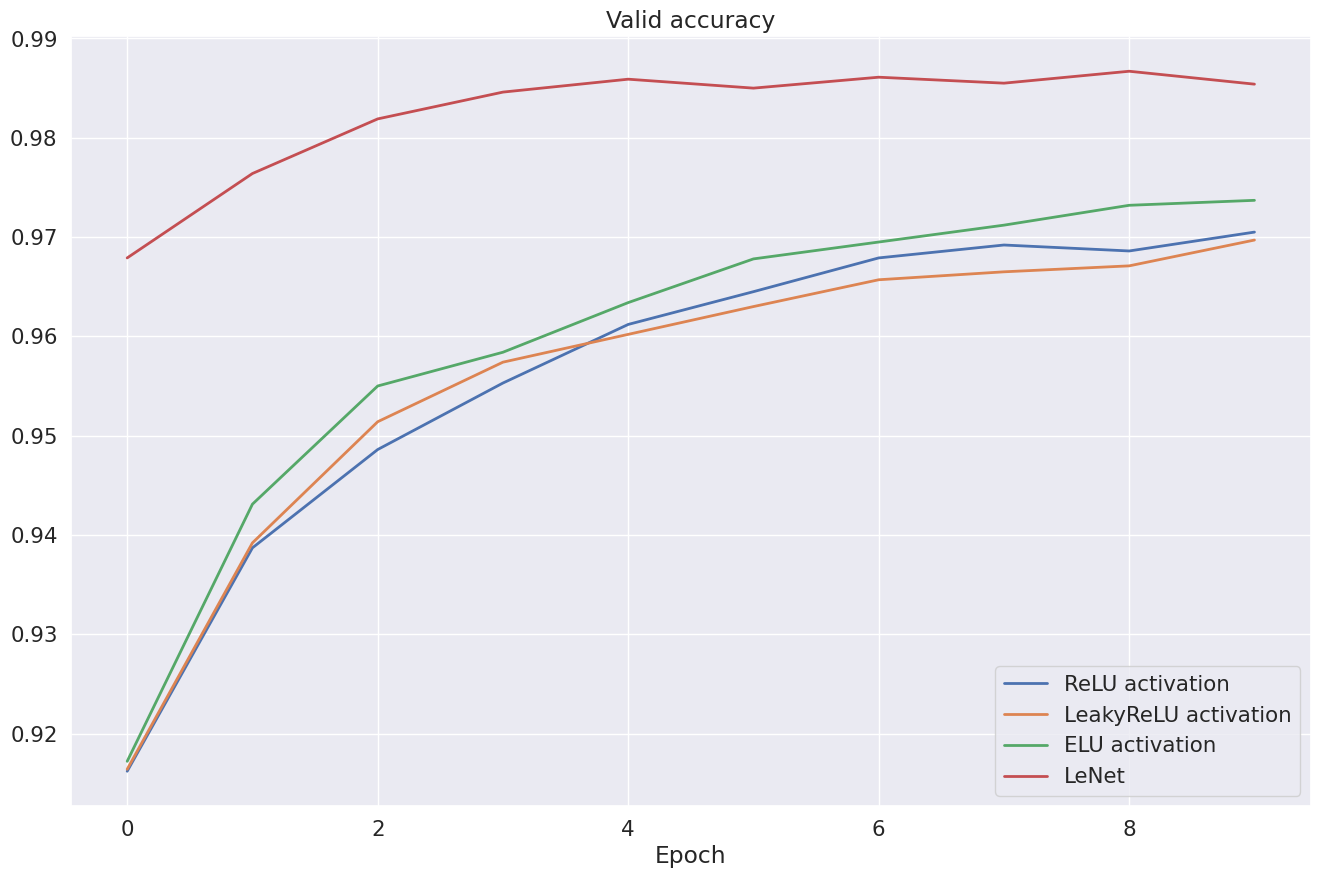

In [80]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** **0.99**

In [82]:
round(lenet_accuracy[9], 2)

0.99